In [413]:
import keras
import numpy as np
from keras import backend as K
from keras import layers
from keras.datasets import mnist
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.model_selection import train_test_split

In [414]:
original_dim = 30000
intermediate_dim = 100
latent_dim = 50

In [415]:
inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [416]:
z_mean.shape

TensorShape([None, 50])

In [417]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [418]:
z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [419]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

In [420]:
# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

In [421]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 30000)]           0         
                                                                 
 encoder (Functional)        [(None, 50),              3010200   
                              (None, 50),                        
                              (None, 50)]                        
                                                                 
 decoder (Functional)        (None, 30000)             3035100   
                                                                 
Total params: 6045300 (23.06 MB)
Trainable params: 6045300 (23.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [422]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [423]:
images_panda = np.zeros((105, 3 * 100 * 100))
images_rabbit = np.zeros((150, 3 * 100 * 100))
for i, img in enumerate(os.listdir('../toys_dataset/images/Panda')):
    im = Image.open('../toys_dataset/images/Panda/' + img)
    im = im.resize((100, 100))
    images_panda[i] = np.array(im).reshape(3 * 100 * 100)
for i, img in enumerate(os.listdir('../toys_dataset/images/Rabbit')):
    im = Image.open('../toys_dataset/images/Rabbit/' + img)
    im = im.resize((100, 100))
    images_rabbit[i] = np.array(im).reshape(3 * 100 * 100)
images_panda = images_panda / 255.
images_rabbit = images_rabbit / 255.

In [424]:
images_panda.shape, images_rabbit.shape

((105, 30000), (150, 30000))

In [425]:
images = np.concatenate((images_panda, images_rabbit))

In [426]:
x_train, x_test = train_test_split(images, test_size=0.2)

In [427]:
x_train.shape

(204, 30000)

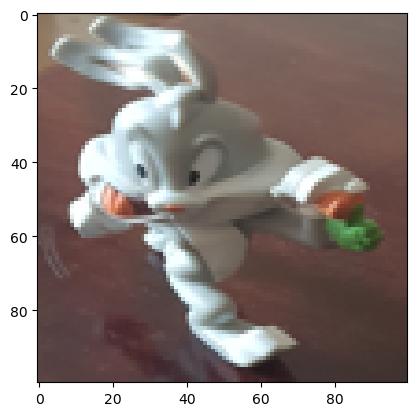

In [428]:
plt.imshow(x_train[0].reshape(100, 100, 3))

In [429]:
vae.compile(optimizer='adam', loss='mse')
vae.fit(x_train, x_train, epochs=100)

Epoch 1/100
7/7 [==============================] - 4s 120ms/step - loss: 154186064.0000
Epoch 2/100
7/7 [==============================] - 1s 119ms/step - loss: 115257528.0000
Epoch 3/100
7/7 [==============================] - 1s 117ms/step - loss: 3231419.5000
Epoch 4/100
7/7 [==============================] - 1s 118ms/step - loss: 144479.2344
Epoch 5/100
7/7 [==============================] - 1s 120ms/step - loss: 44724.0195
Epoch 6/100
7/7 [==============================] - 1s 115ms/step - loss: 27216.6504
Epoch 7/100
7/7 [==============================] - 1s 121ms/step - loss: 24138.3398
Epoch 8/100
7/7 [==============================] - 1s 115ms/step - loss: 22587.7207
Epoch 9/100
7/7 [==============================] - 1s 118ms/step - loss: 22603.8633
Epoch 10/100
7/7 [==============================] - 1s 117ms/step - loss: 23092.0000
Epoch 11/100
7/7 [==============================] - 1s 112ms/step - loss: 22267.7383
Epoch 12/100
7/7 [==============================] - 1s 109ms/st

In [430]:
x_decoded = vae.predict(x_train)

7/7 [==============================] - 0s 10ms/step


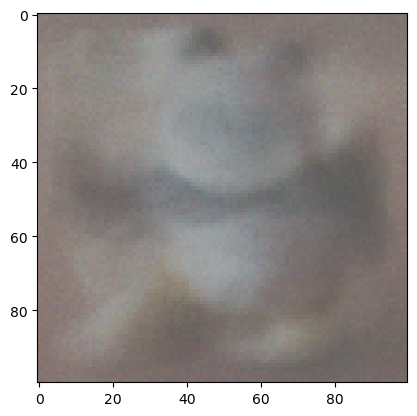

In [435]:
plt.imshow(x_decoded[0].reshape(100, 100, 3))

157/157 [==============================] - 2s 10ms/step


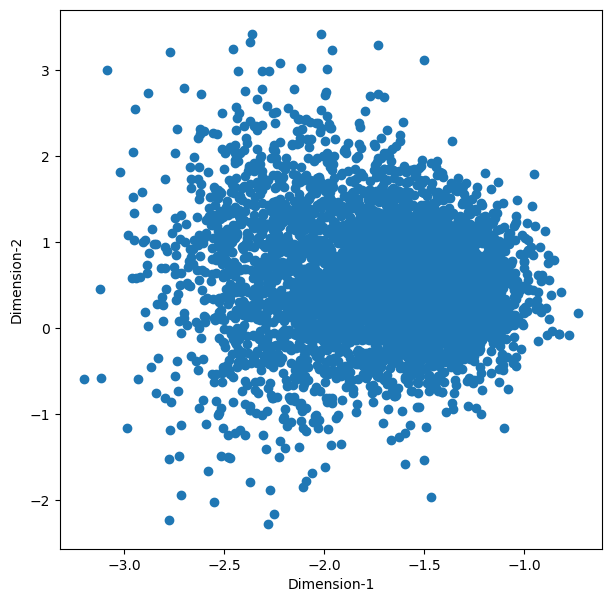

In [431]:
n_to_show = 5000
figsize = 7

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

m, v, z = encoder.predict(example_images)
embeddings = sampling([m, v])

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.xlabel("Dimension-1")
plt.ylabel("Dimension-2")
plt.show()

In [432]:
embeddings.shape

TensorShape([5000, 50])

In [443]:
def plot(x):
    # Display a 2D manifold of the digits
    n = 15  # figure with 15x15 digits
    digit_size = 100
    figure = np.zeros((digit_size * n, digit_size * n))
    # We will sample n points within [-15, 15] standard deviations
    grid_x = np.linspace(-15, 15, n)
    grid_y = np.linspace(-15, 15, n)
    k = 0
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            # x_decoded = decoder.predict(z_sample)
            digit = x[k].reshape(digit_size, digit_size, 3)
            k = k + 1
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure)
    plt.show()

In [444]:
plot(x_train)

ValueError: could not broadcast input array from shape (100,100,3) into shape (100,100)

In [442]:
plot(x_decoded)

ValueError: cannot reshape array of size 30000 into shape (100,100)

1/1 [==============================] - 0s 116ms/step


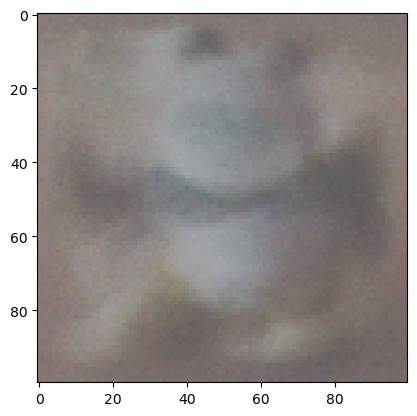

In [447]:
z_sample = np.random.normal(size=(10, latent_dim))
x_decoded = decoder.predict(z_sample)
plt.imshow(x_decoded[0].reshape(100, 100, 3))